In [14]:
import numpy as np
import pandas as pd
df = pd.read_csv('train9.csv')

train_labels = df['label']
train_labels = np.array(train_labels)
# print(train_labels)

train_features = df.iloc[:,:22]
train_features = np.array(train_features)
# print(train_features)

print('train_features', train_features.shape)
print('train_labels', train_labels.shape)

df = pd.read_csv('validate.csv')

# test_labels = df['label']
# test_labels = np.array(test_labels)
# print(test_labels)

test_features = df.iloc[:,:22]
test_features = np.array(test_features)
# print(test_features)

print('test_features', test_features.shape)
# print('test_labels', test_labels.shape)

train_features (1440, 22)
train_labels (1440,)
test_features (100, 22)


In [2]:
# 导入包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from vecstack import stacking
from sklearn.model_selection import GridSearchCV,ParameterGrid
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import warnings

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
warnings.filterwarnings('ignore')


In [9]:
#获取准确率最高的rel_knn_algorithm、rel_weight和rel_nearest_neighbor
from sklearn import neighbors,decomposition
rel_nearest_neighbor = 0
rel_knn_algorithm = ''
rel_weight = ''
knn_algorithms = ['ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']
rel_pre = -1

for knn_algorithm in knn_algorithms:
    #nearest_neighbor参数范围为1-200
    for nearest_neighbor in range(1,101):
        for weight in weights:
            clf = neighbors.KNeighborsClassifier(n_neighbors = nearest_neighbor, weights=weight, algorithm=knn_algorithm)
            clf = clf.fit(train_features, train_labels)

            pre = clf.predict(test_features)
            accuracy = np.sum(pre == test_labels) / pre.shape[0]
            #print('knn_algorithm =',knn_algorithm,',nearest_neighbors =', nearest_neighbor,',weight =',weight,  ',accuracy=', accuracy)
            if accuracy > rel_pre:
                rel_pre = accuracy
                rel_knn_algorithm =knn_algorithm
                rel_weight = weight
                rel_nearest_neighbor = nearest_neighbor

print('rel_knn_algorithm：',rel_knn_algorithm)
print('rel_weight：',rel_weight)
print('rel_nearest_neighbor：',rel_nearest_neighbor)
print('rel_pre：',rel_pre)
from sklearn import neighbors,decomposition
knn_cv = neighbors.KNeighborsClassifier(n_neighbors = rel_nearest_neighbor, weights=rel_weight,
                                     algorithm=rel_knn_algorithm)

rel_knn_algorithm： ball_tree
rel_weight： distance
rel_nearest_neighbor： 4
rel_pre： 0.99375


In [16]:
#获取准确率最高的rel_knn_algorithm、rel_weight和rel_nearest_neighbor
from sklearn import neighbors,decomposition

knn_cv = neighbors.KNeighborsClassifier(n_neighbors = 4, weights='distance',
                                     algorithm='ball_tree')
dt_cv = tree.DecisionTreeClassifier(max_depth = 17,min_samples_leaf =1)


In [10]:
from sklearn import tree
rel_max_depth = 0
rel_min_samples_leaf = 0
rel_pre = -1

for max_depth in range(1,101):
    for min_samples_leaf in range(1,101):
        clf = tree.DecisionTreeClassifier(max_depth = max_depth,min_samples_leaf =min_samples_leaf)
        clf = clf.fit(train_features, train_labels)

        pre = clf.predict(test_features)
        accuracy = np.sum(pre == test_labels) / pre.shape[0]
#        print('max_depth =',max_depth,',min_samples_leaf =', min_samples_leaf,'accuracy=', accuracy)
        if accuracy > rel_pre:
            rel_pre = accuracy
            rel_max_depth =max_depth
            rel_min_samples_leaf = min_samples_leaf
print('rel_pre：',rel_pre)
print('rel_max_depth：',rel_max_depth)
print('rel_min_samples_leaf：',rel_min_samples_leaf)
dt_cv = tree.DecisionTreeClassifier(max_depth = rel_max_depth,min_samples_leaf =rel_min_samples_leaf)

rel_pre： 0.94375
rel_max_depth： 17
rel_min_samples_leaf： 1


In [11]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
# 创建分类器对象
clf = GaussianNB()
#用训练数据拟合分类器模型
nb_sv = clf.fit(train_features.astype(np.float64), train_labels)
#用训练好的分类器去预测test_features数据的标签类
label_predict = nb_sv.predict(test_features.astype(np.float64))
accuracy = np.sum(label_predict == test_labels) / label_predict.shape[0]

print('GaussianNB accuracy=', accuracy)

GaussianNB accuracy= 0.9875


In [12]:
# 模型融合
model_list = [knn_cv,dt_cv,nb_sv]
rel_n_folds = 0
rel_pre = -1
x = []
y = []

for n_fold in range(2,101, 1):
    S_train, S_test = stacking(model_list, train_features, train_labels,test_features, regression=False, n_folds=7)
    # # Initialize 2-nd level model
    model = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 1)
    # # Fit 2-nd level model
    model_s = model.fit(S_train, train_labels)
    # # Predict
    y_pred = model_s.predict(S_test)
    # Final prediction score
    f1_score = metrics.f1_score(y_pred, test_labels,average="micro")
    x.append(n_fold)
    y.append(f1_score)
    print('n_folds =',n_fold,'f1_score=', f1_score)
    if f1_score >= rel_pre:
        rel_pre = f1_score
        rel_n_folds = n_fold
# acc_score_test = metrics.accuracy_score(y_pred, test_labels)
# precision_score_test = metrics.precision_score(y_pred, test_labels, average="micro")
# recall_score_test = metrics.recall_score(y_pred, test_labels, average="micro")
# f1_score_test = metrics.f1_score(y_pred, test_labels, average="micro")

# # scoring='roc_auc'是用来检测定性数据结果的，比如好人坏人，是和否等，即结果为0或1的数据预测
# # roc_auc_score_test = metrics.roc_auc_score(y_pred, test_labels,average="micro")

# print('Final 测试集准确率：{}\n'.format(acc_score_test))
# print('Final 测试集精确率：{}\n'.format(precision_score_test))
# print('Final 测试集召回率：{}\n'.format(recall_score_test))
# print('Final 测试集f1评分：{}\n'.format(f1_score_test))
# print('Final 测试集AUC值：{}\n'.format(roc_auc_score_test))
        
        
# model_est(model_dict_s, x_train, x_test, y_train, y_test) 



n_folds = 2 f1_score= 0.975
n_folds = 3 f1_score= 0.9875
n_folds = 4 f1_score= 0.9875
n_folds = 5 f1_score= 0.9875
n_folds = 6 f1_score= 0.9875
n_folds = 7 f1_score= 0.99375
n_folds = 8 f1_score= 0.99375
n_folds = 9 f1_score= 0.99375
n_folds = 10 f1_score= 0.99375
n_folds = 11 f1_score= 0.99375
n_folds = 12 f1_score= 0.99375
n_folds = 13 f1_score= 0.99375
n_folds = 14 f1_score= 0.99375
n_folds = 15 f1_score= 0.99375
n_folds = 16 f1_score= 0.99375
n_folds = 17 f1_score= 0.99375
n_folds = 18 f1_score= 0.99375
n_folds = 19 f1_score= 0.99375
n_folds = 20 f1_score= 0.99375
n_folds = 21 f1_score= 0.99375
n_folds = 22 f1_score= 0.99375
n_folds = 23 f1_score= 0.99375
n_folds = 24 f1_score= 0.99375
n_folds = 25 f1_score= 0.99375
n_folds = 26 f1_score= 0.99375
n_folds = 27 f1_score= 0.99375
n_folds = 28 f1_score= 0.99375
n_folds = 29 f1_score= 0.99375
n_folds = 30 f1_score= 0.99375
n_folds = 31 f1_score= 0.99375
n_folds = 32 f1_score= 0.99375
n_folds = 33 f1_score= 0.99375
n_folds = 34 f1_score=

In [21]:
# 模型融合
model_list = [knn_cv,dt_cv,nb_sv]

S_train, S_test = stacking(model_list, train_features, train_labels,test_features, regression=False, n_folds=7)
# # Initialize 2-nd level model
model = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 1)
# # Fit 2-nd level model
model_s = model.fit(S_train, train_labels)
# # Predict
y_pred = model_s.predict(S_test)

pred = []
for i in y_pred:
    pred.append(int(i))
print(pred)

[2, 7, 3, 5, 0, 2, 7, 2, 0, 2, 0, 0, 5, 1, 3, 4, 8, 7, 1, 9, 8, 5, 7, 8, 1, 4, 6, 9, 0, 0, 3, 0, 8, 2, 9, 7, 9, 3, 0, 6, 3, 7, 7, 1, 1, 9, 0, 9, 1, 9, 6, 6, 2, 2, 8, 4, 9, 2, 3, 7, 7, 4, 9, 8, 8, 2, 0, 5, 6, 8, 9, 8, 5, 4, 7, 9, 2, 2, 1, 7, 3, 1, 8, 1, 1, 5, 4, 3, 5, 6, 2, 1, 4, 4, 3, 1, 8, 0, 8, 1]


In [24]:
pred = [2, 7, 3, 5, 0, 2, 7, 2, 0, 2, 0, 0, 5, 1, 3, 4, 8, 7, 1, 9, 8, 5, 7, 8, 1, 4, 6, 9, 0, 0, 3, 0, 8, 2, 9, 7, 9, 3, 0, 6, 3, 7, 7, 1, 1, 9, 0, 9, 1, 9, 6, 6, 2, 2, 8, 4, 9, 2, 5, 7, 7, 4, 9, 8, 8, 2, 0, 5, 6, 8, 5, 8, 5, 4, 7, 9, 2, 2, 1, 7, 3, 1, 8, 1, 1, 5, 4, 3, 5, 6, 2, 1, 4, 4, 3, 1, 8, 0, 8, 1]

In [25]:
df = pd.read_csv('validate.csv')
df['label']=pred #增加新的列company
df.head()
#以下保存指定的列到新的csv文件，index=0表示不为每一行自动编号，header=1表示行首有字段名称
df.to_csv('验证集预测结果.csv',index=0,header=1)

In [13]:
print(rel_pre)

0.99375


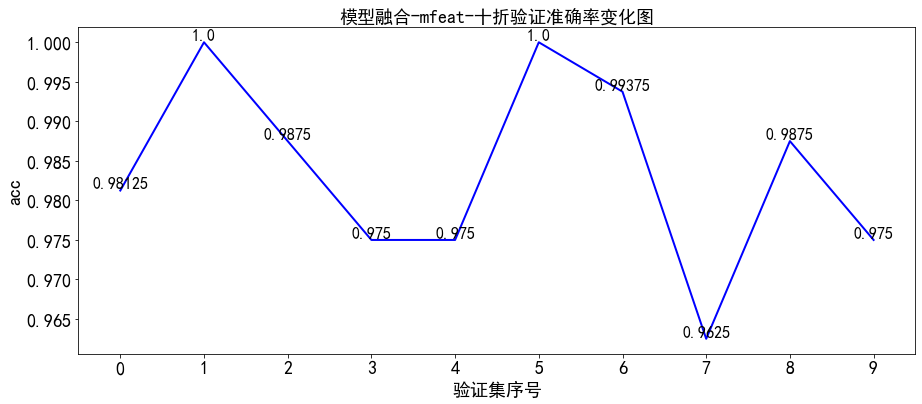

In [68]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from pylab import *                                 #支持中文
mpl.rcParams['font.sans-serif'] = ['SimHei']
from matplotlib.pyplot import MultipleLocator
#从pyplot导入MultipleLocator类，这个类用于设置刻度间隔

#X轴，Y轴数据
x = [0,1,2,3,4,5,6,7,8,9]
y = [0.98125,1.0,0.9875,0.975,0.975,1.0,0.99375,0.9625,0.9875,0.975]
plt.figure(figsize=(15,6)) #创建绘图对象
plt.plot(x,y,"b",linewidth=2)   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("验证集序号",size=18) #X轴标签
plt.ylabel("acc",size=18)  #Y轴标签
plt.title("模型融合-mfeat-十折验证准确率变化图",size=18) #图标题

# 设置数字标签
for a, b in zip(x, y):
    plt.text(a, b, b, ha='center', va='bottom',size=16)
x_major_locator=MultipleLocator(1)
#把x轴的刻度间隔设置为1，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(-0.5,9.5)
#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白

plt.savefig("模型融合-mfeat-十折验证.png") #保存图
plt.show()  #显示图

In [69]:
mean(y)

0.98375